# Exploratory Data Analysis of WELFake Dataset

This notebook explores the WELFake dataset to understand its basic characteristics and identify patterns that distinguish real from fake news articles.

## 1. Introduction

The WELFake dataset is a comprehensive collection that combines real and fake news articles from various sources. It was created by merging four different datasets: PolitiFact, GossipCop, Reuters, and BuzzFeed.

This exploratory data analysis will help us understand:
- The distribution and balance of real vs. fake news
- Key linguistic differences between real and fake articles
- Visual and structural patterns that might distinguish fake news
- Potential features that could be useful for classification models

Understanding these patterns is essential before building any machine learning models for fake news detection.

## 2. Setting Up and Loading the Dataset

First, we'll import all necessary libraries for our analysis. We need pandas and numpy for data manipulation, matplotlib and seaborn for visualization, and NLTK for text processing. We'll also suppress warnings to keep our notebook clean.

In [1]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [2]:
# Load the WELFake dataset
df = pd.read_csv('../data/WELFake_Dataset.csv')

## 3. Initial Data Exploration

Let's take a first look at the data:

In [3]:
# Display the first few rows
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
# Check the shape of the dataset
print(f"Dataset dimensions: {df.shape[0]} rows and {df.shape[1]} columns")

Dataset dimensions: 72134 rows and 4 columns


In [5]:
# Get basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


### Understanding the Dataset Structure

Looking at the first few rows, we can see that the dataset contains four columns:
- `Unnamed: 0`: An index column (not useful for our analysis)
- `title`: The headline of the news article
- `text`: The body content of the article
- `label`: Binary classification where 0 = Real news and 1 = Fake news

The dataset is substantial with 72,134 rows, giving us plenty of examples to analyze patterns.

## 4. Handling Missing Values

Before proceeding with analysis, we need to check for and handle missing values, which could affect our results or cause errors in processing.

In [6]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Unnamed: 0      0
title         558
text           39
label           0
dtype: int64


### Cleaning the Data

We found 558 missing titles and 39 missing text entries. For our analysis, we need complete records with both title and text, so we'll remove these incomplete entries. The removal of 597 rows (less than 1% of our data) won't significantly impact our analysis but will ensure data quality.

In [7]:
# Drop rows with missing values
df_clean = df.dropna()
print(f"Original dataset size: {df.shape[0]} rows")
print(f"Cleaned dataset size: {df_clean.shape[0]} rows")
print(f"Removed {df.shape[0] - df_clean.shape[0]} rows with missing values")

Original dataset size: 72134 rows
Cleaned dataset size: 71537 rows
Removed 597 rows with missing values


## 5. Label Distribution

A well-balanced dataset is crucial for training unbiased models. Let's check the distribution of real and fake news articles to ensure we have sufficient examples of each class.

In [8]:
# Count the number of real and fake news articles
label_counts = df_clean['label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']
label_counts['Percentage'] = (label_counts['Count'] / label_counts['Count'].sum() * 100).round(2)
label_counts['Label'] = label_counts['Label'].map({0: 'Real', 1: 'Fake'})

print(label_counts)

  Label  Count  Percentage
0  Fake  36509       51.04
1  Real  35028       48.96


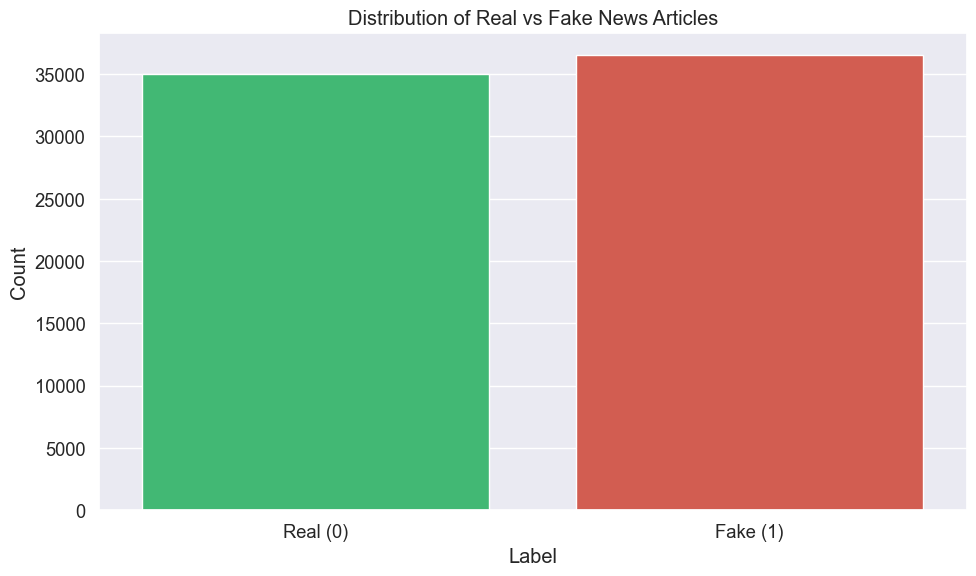

In [9]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df_clean, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribution of Real vs Fake News Articles')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.show()

### Dataset Balance Analysis

The dataset is well-balanced with 48.96% real news (35,028 articles) and 51.04% fake news (36,509 articles). This near-equal distribution is ideal for machine learning, as it reduces the risk of class bias during model training.

## 6. Text Length Analysis

Text length can be a distinguishing feature between real and fake news. Professional news sources might follow certain length standards, while fake news could be either unusually short (for clickbait) or unnecessarily long. We'll analyze title length, text length, and word count.

In [10]:
# Add columns for text length
df_clean['title_length'] = df_clean['title'].apply(len)
df_clean['text_length'] = df_clean['text'].apply(len)
df_clean['word_count'] = df_clean['text'].apply(lambda x: len(x.split()))

In [11]:
# Get summary statistics for text length by label
length_stats = df_clean.groupby('label')[['title_length', 'text_length', 'word_count']].agg(['mean', 'median'])
print("Text length statistics by label (0=Real, 1=Fake):")
print(length_stats)

Text length statistics by label (0=Real, 1=Fake):
      title_length        text_length          word_count       
              mean median        mean  median        mean median
label                                                           
0        68.790596   67.0  3495.31669  2642.5  577.615536  427.0
1        85.131584   83.0  3098.34586  2235.0  512.850886  373.0


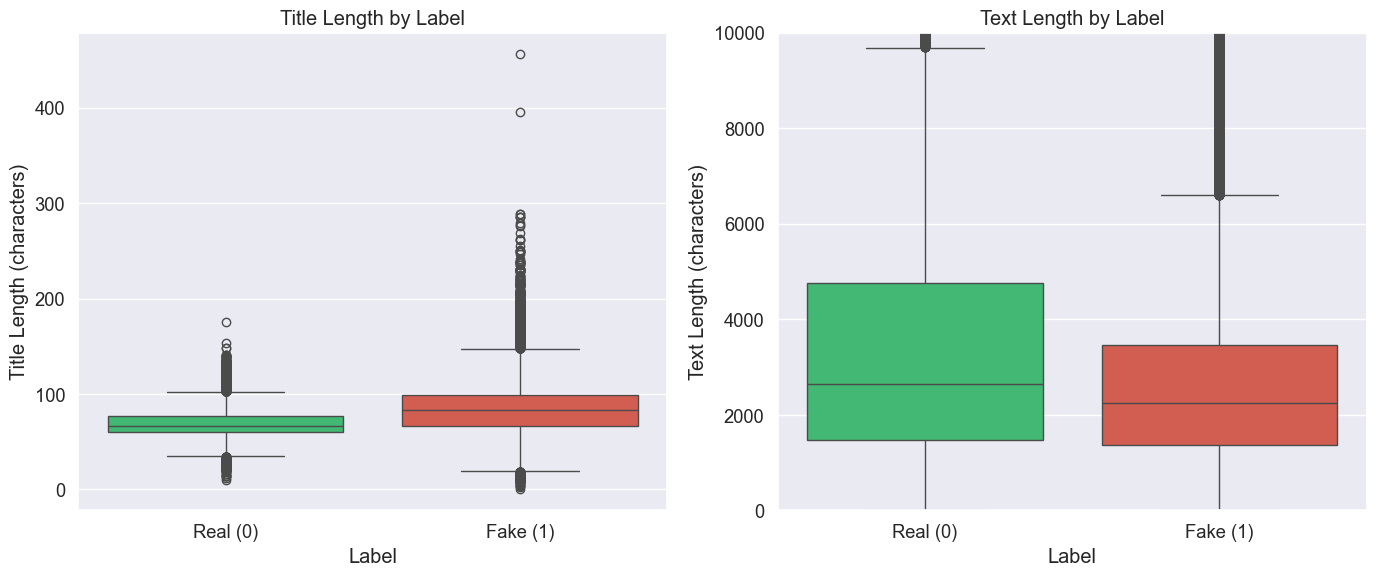

In [12]:
# Visualize title and text length distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_clean, x='label', y='title_length', palette=['#2ecc71', '#e74c3c'])
plt.title('Title Length by Label')
plt.xlabel('Label')
plt.ylabel('Title Length (characters)')
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])

plt.subplot(1, 2, 2)
sns.boxplot(data=df_clean, x='label', y='text_length', palette=['#2ecc71', '#e74c3c'])
plt.title('Text Length by Label')
plt.xlabel('Label')
plt.ylabel('Text Length (characters)')
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])
plt.ylim(0, 10000)  # Limit y-axis for better visualization

plt.tight_layout()
plt.show()

### Length Comparison Insights

The statistics reveal interesting patterns:

1. **Title Length**: Fake news titles tend to be longer (mean: 85.13 characters) compared to real news (mean: 68.79 characters). This suggests fake news articles might use longer, more sensationalist headlines to attract attention.

2. **Text Length**: Interestingly, real news articles are generally longer (mean: 3,495 characters) than fake news (mean: 3,098 characters). This might indicate that legitimate news sources provide more comprehensive coverage.

3. **Word Count**: Similarly, real news contains more words on average (578 words) compared to fake news (513 words).

These length differences could serve as useful features in a classification model.

## 7. Common Words Analysis

The vocabulary used in news articles can provide significant clues about their authenticity. We'll analyze the most frequent words in both real and fake news after removing common stop words (like "the", "a", "and") that don't carry much meaning.

In [13]:
# Download NLTK resources
nltk.download('stopwords')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/amid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Word Frequency Analysis Setup

We'll use NLTK to remove stop words and create a function to identify the most common words in our corpus. This will help us understand vocabulary differences between real and fake news.

In [14]:
# Function to get most common words
def get_common_words(texts, n=50):
    """Extract most common words from a list of texts after removing stopwords"""
    # Join all texts
    text = ' '.join(texts)
    
    # Convert to lowercase and split
    words = text.lower().split()
    
    # Remove stopwords, punctuation, and short words
    words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 3]
    
    # Count word frequency
    return Counter(words).most_common(n)

In [15]:
# Get most common words for real and fake news
real_common_words = get_common_words(df_clean[df_clean['label'] == 0]['text'])
fake_common_words = get_common_words(df_clean[df_clean['label'] == 1]['text'])

# Create DataFrames for visualization
real_words_df = pd.DataFrame(real_common_words, columns=['Word', 'Count'])
fake_words_df = pd.DataFrame(fake_common_words, columns=['Word', 'Count'])

# Display the common words
print("Most common words in real news:")
print(real_words_df)

print("\nMost common words in fake news:")
print(fake_words_df)

Most common words in real news:
            Word   Count
0           said  122295
1          trump   70066
2          would   61810
3      president   41059
4           also   36081
5         people   33430
6          could   29354
7          state   28248
8         united   27533
9           last   26083
10    republican   24121
11          told   23799
12    government   23783
13         house   23781
14          like   23010
15        states   22001
16         first   21268
17          many   20644
18        former   19434
19         white   18607
20       clinton   18217
21        donald   17133
22          even   17128
23      campaign   16992
24      national   16786
25     political   16637
26       percent   16183
27         since   15738
28     including   15737
29         party   15483
30      american   15450
31          made   15385
32          time   15303
33    washington   15138
34          news   15019
35         obama   14887
36      security   14887
37          make  

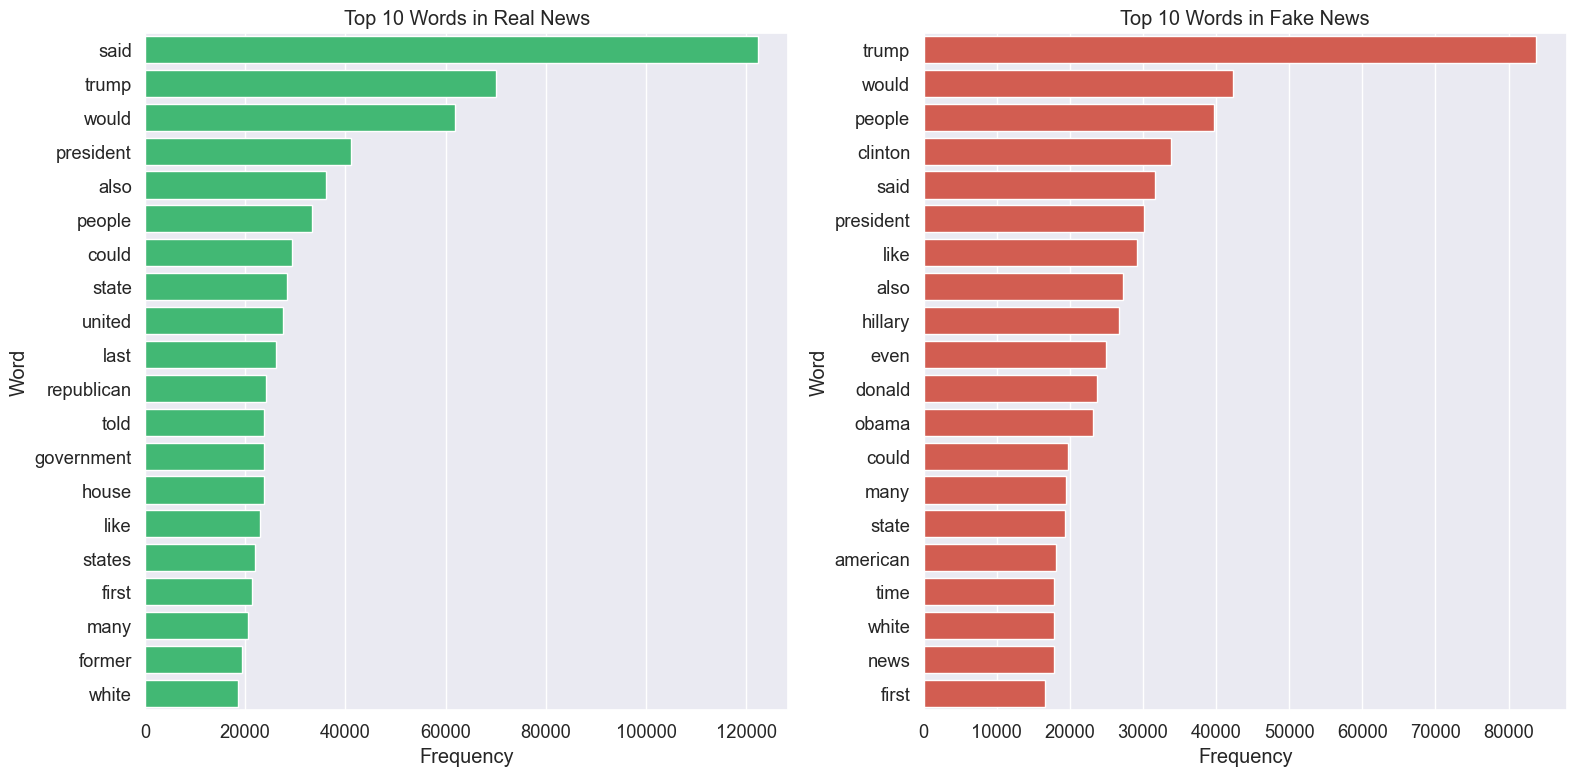

In [16]:
# Visualize most common words
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.barplot(data=real_words_df.head(20), x='Count', y='Word', color='#2ecc71')
plt.title('Top 10 Words in Real News')
plt.xlabel('Frequency')

plt.subplot(1, 2, 2)
sns.barplot(data=fake_words_df.head(20), x='Count', y='Word', color='#e74c3c')
plt.title('Top 10 Words in Fake News')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

### Vocabulary Pattern Insights

The most common words analysis reveals distinct patterns:

1. **Attribution Words**: "Said" appears much more frequently in real news (122,295 times) compared to fake news (31,617 times). This suggests real news more often attributes information to sources.

2. **Political References**: Both categories mention "Trump" frequently, but fake news has more references to specific political figures like "Clinton", "Hillary", and "Obama".

3. **Institutional Focus**: Real news uses more institutional terms like "government", "states", and "united", suggesting more focus on official entities.

4. **Emotional Language**: Fake news includes words like "even" more frequently, which can be used for emphasis or to express surprise.

The difference in language usage provides valuable insights into how fake news differs from legitimate reporting.

## 8. Title Analysis

Headlines are crucial in news articles—they create the first impression and determine if readers will engage with the content. Sensationalist titles are often associated with clickbait and fake news. Let's examine specific characteristics of titles that might distinguish fake from real news.

In [23]:
# Analyze title characteristics without creating new features
def analyze_title_characteristics(titles, label_name):
    """Analyze title characteristics for a given label"""
    
    # Count titles with ALL CAPS words
    has_allcaps = sum(1 for title in titles if any(word.isupper() and word.isalpha() and len(word) > 2 for word in str(title).split()))
    
    # Count titles with exclamation marks
    has_exclamation = sum(1 for title in titles if '!' in str(title))
    
    # Count titles with question marks  
    has_question = sum(1 for title in titles if '?' in str(title))
    
    total = len(titles)
    
    print(f"\n{label_name} News Title Characteristics:")
    print(f"Titles with ALL CAPS words: {has_allcaps} ({has_allcaps/total*100:.1f}%)")
    print(f"Titles with exclamation marks: {has_exclamation} ({has_exclamation/total*100:.1f}%)")
    print(f"Titles with question marks: {has_question} ({has_question/total*100:.1f}%)")
    
    return {
        'allcaps_pct': has_allcaps/total*100,
        'exclamation_pct': has_exclamation/total*100,
        'question_pct': has_question/total*100
    }

In [24]:
# Analyze real news titles
real_titles = df_clean[df_clean['label'] == 0]['title']
real_stats = analyze_title_characteristics(real_titles, "Real")


Real News Title Characteristics:
Titles with ALL CAPS words: 2789 (8.0%)
Titles with exclamation marks: 70 (0.2%)
Titles with question marks: 857 (2.4%)


In [25]:
# Analyze fake news titles
fake_titles = df_clean[df_clean['label'] == 1]['title']
fake_stats = analyze_title_characteristics(fake_titles, "Fake")


Fake News Title Characteristics:
Titles with ALL CAPS words: 18468 (50.6%)
Titles with exclamation marks: 3960 (10.8%)
Titles with question marks: 2672 (7.3%)


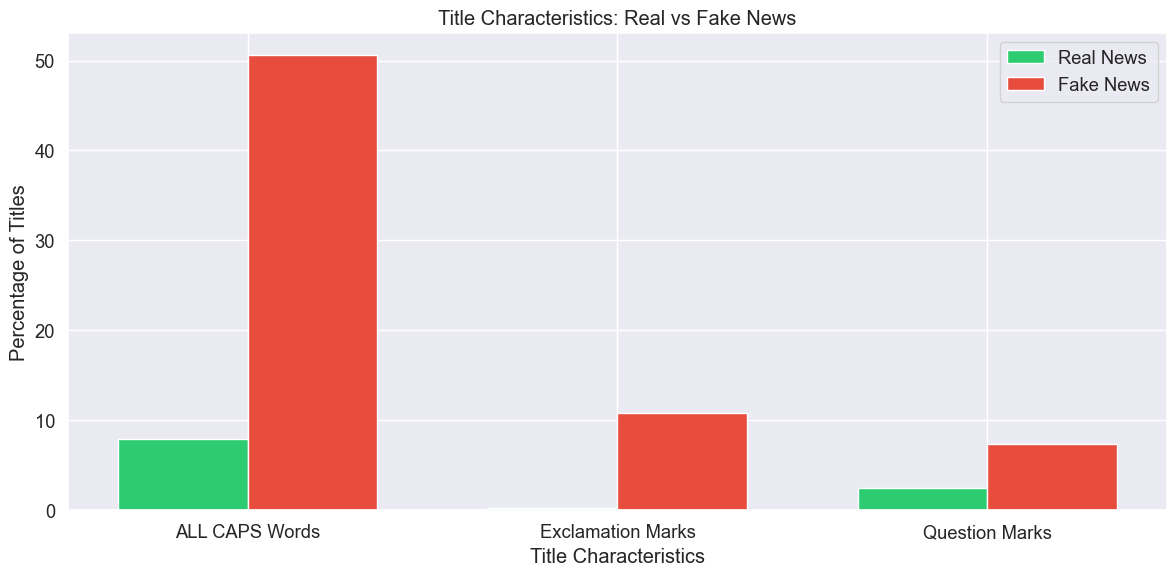

In [26]:
# Visualize the comparison
characteristics = ['ALL CAPS Words', 'Exclamation Marks', 'Question Marks']
real_values = [real_stats['allcaps_pct'], real_stats['exclamation_pct'], real_stats['question_pct']]
fake_values = [fake_stats['allcaps_pct'], fake_stats['exclamation_pct'], fake_stats['question_pct']]

x = np.arange(len(characteristics))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, real_values, width, label='Real News', color='#2ecc71')
plt.bar(x + width/2, fake_values, width, label='Fake News', color='#e74c3c')

plt.xlabel('Title Characteristics')
plt.ylabel('Percentage of Titles')
plt.title('Title Characteristics: Real vs Fake News')
plt.xticks(x, characteristics)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# Show some examples of titles with these characteristics
print("\nExamples of titles with ALL CAPS words:")
print("Real news examples:")
real_allcaps = [title for title in real_titles if any(word.isupper() and word.isalpha() and len(word) > 2 for word in str(title).split())]
for i, title in enumerate(real_allcaps[:3]):
    print(f"  {i+1}. {title}")


Examples of titles with ALL CAPS words:
Real news examples:
  1. No Change Expected for ESPN Political Agenda Despite Huge Subscriber Decline - Breitbart
  2. MSNBC, DNC reach deal to host Democratic debate in New Hampshire
  3. CNN Advertises Job Listing for Full Time ’Fake News’ Reporter


In [30]:
print("\nFake news examples:")
fake_allcaps = [title for title in fake_titles if any(word.isupper() and word.isalpha() and len(word) > 2 for word in str(title).split())]
for i, title in enumerate(fake_allcaps[:3]):
    print(f"  {i+1}. {title}")


Fake news examples:
  1. LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]
  2. UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO]
  3. SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice


In [31]:
# Show examples of titles with exclamation marks
print("\nExamples of titles with exclamation marks:")
print("Real news examples:")
real_exclamation = [title for title in real_titles if '!' in str(title)]
for i, title in enumerate(real_exclamation[:3]):
    print(f"  {i+1}. {title}")


Examples of titles with exclamation marks:
Real news examples:
  1. ‘Take The Money!!’: Emails Show How Clinton Campaign Manages Lobbyist Donations
  2. How the Grinch Ended Up in Court! - The New York Times
  3. Lordy! Ex-FBI chief sets Twitter abuzz but @realDonaldTrump is silent


In [32]:
print("\nFake news examples:")
fake_exclamation = [title for title in fake_titles if '!' in str(title)]
for i, title in enumerate(fake_exclamation[:3]):
    print(f"  {i+1}. {title}")


Fake news examples:
  1. UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO]
  2. About Time! Christian Group Sues Amazon and SPLC for Designation as Hate Group
  3. BOOM! Danish Government Considers Seizing Migrant’s Valuables To Pay For Benefits


In [33]:
# Show examples of titles with question marks
print("\nExamples of titles with question marks:")
print("Real news examples:")
real_question = [title for title in real_titles if '?' in str(title)]
for i, title in enumerate(real_question[:3]):
    print(f"  {i+1}. {title}")


Examples of titles with question marks:
Real news examples:
  1. TV Viewership Falls in N.F.L. and Premier League: A Blip, or Something Worse? - The New York Times
  2. Campaign Over, President Trump Will Hold a (What Else?) Campaign Rally - The New York Times
  3. Will Latino loathing of Trump drive a voter movement to swing the election?


In [35]:
print("\nFake news examples:")
fake_exclamation = [title for title in fake_titles if '?' in str(title)]
for i, title in enumerate(fake_exclamation[:3]):
    print(f"  {i+1}. {title}")


Fake news examples:
  1. Do You Belong To An Extraterrestrial Lineage?
  2. JOE BIDEN’S SHOCKING ANNOUNCEMENT: “What the hell, man?” [Video]
  3. “PROGRESSIVE” DE BLASIO VISITS IOWA: Denies He’s Running For President…So He Just Wanted To Visit Iowa?


### Title Characteristics Findings

The title analysis reveals striking differences:

1. **All-Caps Words**: 50.6% of fake news titles contain words in ALL CAPS, compared to only 8.0% of real news titles. ALL CAPS is often used to create drama or urgency.

2. **Exclamation Marks**: 10.8% of fake news titles contain exclamation marks, versus just 0.2% of real news titles—a 54x difference! Exclamation marks often add unnecessary emphasis or emotional appeal.

3. **Question Marks**: 7.3% of fake news titles contain question marks, compared to 2.4% of real news titles. Questions can create curiosity or imply uncertainty.

These dramatic differences in title styling could be powerful indicators of potentially fake content.

## 10. Saving Processed Data

Now that we've completed our analysis and feature engineering, we'll save the cleaned and enhanced dataset for future modeling work.

In [36]:
# Save the cleaned dataset
df_clean.to_csv('../data/WELFake_cleaned.csv', index=False)
print("Cleaned dataset saved to 'WELFake_cleaned.csv'")

Cleaned dataset saved to 'WELFake_cleaned.csv'


The cleaned dataset now includes our engineered features (title length, text length, word count, and title characteristics), which will be valuable for building classification models.

## 11. Key Findings

Based on our exploratory data analysis of the WELFake dataset, here are the key findings:

### Key Findings

1. **Dataset Characteristics**
   - Well-balanced dataset: 48.96% real news vs. 51.04% fake news
   - Few missing values (less than 1% of records)

2. **Content Length Patterns**
   - Fake news titles are typically longer (85 vs. 69 characters on average)
   - Real news articles tend to have longer body text (3,495 vs. 3,098 characters on average)

3. **Linguistic Differences**
   - Real news uses more attribution words ("said" appears 4x more often)
   - Fake news references specific political figures more frequently
   - Real news focuses more on institutions and official entities

4. **Title Characteristics**
   - Fake news titles use ALL CAPS words nearly 6x more often (50.6% vs. 8.0%)
   - Fake news titles use exclamation marks 54x more often (10.8% vs. 0.2%)
   - Fake news titles use question marks 3x more often (7.3% vs. 2.4%)

The WELFake dataset provides rich opportunities for developing effective fake news detection models, with clear distinguishing features between real and fake news articles.